In [1]:
# Modelling 2D VTI in Devito.
# Defined by elastic tensor components
# First attempt using a centered source

In [2]:
%matplotlib notebook

from devito import *
from examples.seismic.source import RickerSource, TimeAxis
from examples.seismic import plot_image, Model
import numpy as np

from sympy import init_printing, latex
init_printing(use_latex=True)



In [3]:
extent = (150., 150.)
# Grid is 2km x 2km with spacing 10m
shape = (151, 151)

# Define x and z as spatial dimentions for Sympy
x = SpaceDimension(name='x', spacing=Constant(name='h_x', value=extent[0]/(shape[0]-1)))
# Dimension called x, with constant spacing of 10 (called h_x) 
z = SpaceDimension(name='z', spacing=Constant(name='h_z', value=extent[1]/(shape[1]-1)))
grid = Grid(extent=extent, shape=shape, dimensions=(x, z))

In [4]:
t0, tn = 0., 75.
dt = (1. / np.sqrt(2.)) / 2500.
time_range = TimeAxis(start=t0, stop=tn, step=dt) #Set up time axis object for ricker source

src = RickerSource(name='src', grid=grid, f0=0.100, time_range=time_range) # Ricker wavelet source
src.coordinates.data[:] = np.array([75., 75.])
# 2 element array containing x and z positions of source
# Position is defined in meters, rather than grid points
#src.show() # Show the source function

In [5]:
so = 4 # Spatial derivatives are eighth order accurate
# Grids are staggered to prevent pressure decoupling. Note that staggering is done in corresponding directions
vx = TimeFunction(name='vx', grid=grid, staggered=x, space_order=so) # Velocity field x
vz = TimeFunction(name='vz', grid=grid, staggered=z, space_order=so) # Velocity field z
# staggered=x entails discretization on x edges
txx = TimeFunction(name='txx', grid=grid, staggered=NODE, space_order=so)
tzz = TimeFunction(name='tzz', grid=grid, staggered=NODE, space_order=so)
txz = TimeFunction(name='txz', grid=grid, staggered=(x, z), space_order=so)
# Stress axis for normal and shear stresses

In [6]:
# The source injection term
src_xx = src.inject(field=txx.forward, expr=src) 
src_zz = src.inject(field=tzz.forward, expr=src)

In [7]:
rho = Function(name="rho", grid=grid, space_order=2) #Bouyancy
rho.data[:] = 1/1900.

# k_1,2,3,4 refer to components in the stress tensor as follows:
#
# | k_1 k_2  0  |
# |             |
# | k_2 k_3  0  |
# |             |
# |  0   0  k_4 |

# Adapted from Juhlin 1995 and Okaya and McEvilly 2003

# Tensor components can be spatially variant
k_1= Function(name="k1", grid=grid, space_order=2)
k_1.data[:] = 2700.*1.1 # Parameters scaled relative to values for isotropic case (lambda = 1300, mu = 700)
k_2= Function(name="k2", grid=grid, space_order=2)
k_2.data[:] = 1300.*1.
k_3= Function(name="k3", grid=grid, space_order=2)
k_3.data[:] = 2700.*1.
k_4= Function(name="k4", grid=grid, space_order=2)
k_4.data[:] = 700.*1.

u_vx = Eq(vx.forward, vx + dt*rho*(txx.dx + txz.dz)) #PDEs for updating all fields

u_vz = Eq(vz.forward, vz + dt*rho*(txz.dx + tzz.dz))

u_txx = Eq(txx.forward,
           txx + dt*k_1*vx.forward.dx 
           + dt*k_2*vz.forward.dz)

u_tzz = Eq(tzz.forward,
           tzz + dt*k_2*vx.forward.dx 
           + dt*k_3*vz.forward.dz)

u_txz = Eq(txz.forward,
          txz + dt*k_4*(vx.forward.dz + vz.forward.dx))

In [8]:
op = Operator([u_vx, u_vz, u_txx, u_tzz, u_txz] + src_xx + src_zz) #Operator can iterate multiple PDEs at once
#Source is injected in xx and zz directions

In [9]:
# Reset the fields
vx.data[:] = 0. #Velocity components
vz.data[:] = 0.
txx.data[:] = 0. #Symmetric stress tensors
tzz.data[:] = 0.
txz.data[:] = 0.

op()

Operator `Kernel` run in 131.67 s


<IPython.core.display.Javascript object>


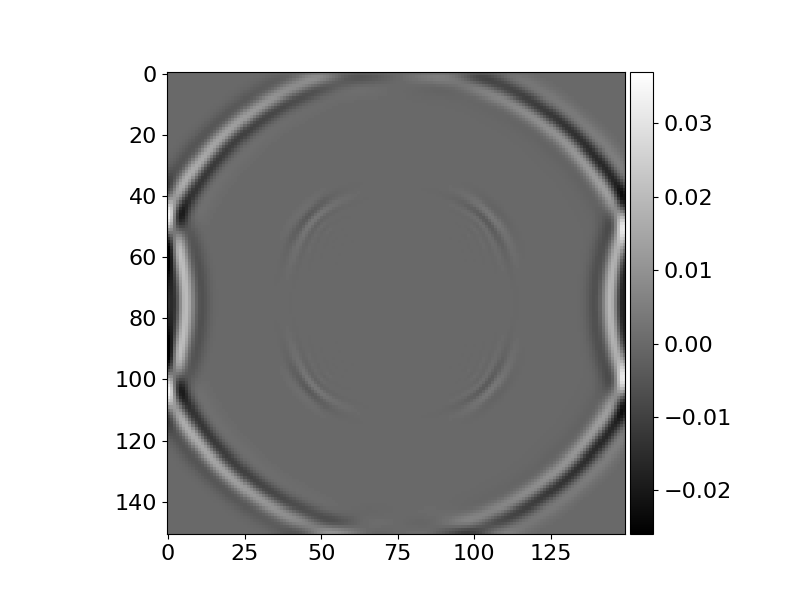

In [10]:
plot_image(vx.data[0])


In [12]:
plot_image(vz.data[0])

In [13]:
plot_image(txx.data[0])

In [14]:
plot_image(tzz.data[0])

In [15]:
plot_image(txz.data[0])